In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
class DataExplorer:
    def __init__(self, train_dir, val_dir, test_dir):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir

    def get_image_statistics(self):
        subsets = {'Train': self.train_dir, 'Validation': self.val_dir, 'Test': self.test_dir}
        stats = {}
        for subset, dir_path in subsets.items():
            stats[subset] = {}
            for label in os.listdir(dir_path):
                label_dir = os.path.join(dir_path, label)
                if os.path.isdir(label_dir):
                    num_images = len(os.listdir(label_dir))
                    stats[subset][label] = num_images
        return stats

    def get_patient_statistics(self):
        patient_stats = {}
        for subset in ['train', 'val']:
            subset_dir = getattr(self, f'{subset.lower()}_dir')
            patient_stats[subset] = {}
            for label in os.listdir(subset_dir):
                if label != 'NORMAL':
                    label_dir = os.path.join(subset_dir, label)
                    if os.path.isdir(label_dir):
                        patient_ids = [fname.split('_')[0] for fname in os.listdir(label_dir)]
                        unique_patients = set(patient_ids)
                        patient_stats[subset][label] = len(unique_patients)
        return patient_stats

    def display_sample_images(self, num_images=5):
        fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))
        for i, subset in enumerate(['train', 'val']):
            subset_dir = getattr(self, f'{subset.lower()}_dir')
            for j, label in enumerate(os.listdir(subset_dir)):
                label_dir = os.path.join(subset_dir, label)
                if os.path.isdir(label_dir):
                    images = [os.path.join(label_dir, img) for img in os.listdir(label_dir)[:num_images]]
                    for k, img_path in enumerate(images):
                        img = cv2.imread(img_path)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        axes[k, j].imshow(img)
                        axes[k, j].set_title(f'{subset} - {label}')
                        axes[k, j].axis('off')
        plt.show()

In [3]:
class ChestXRayClassifier:
    def __init__(self, img_size=224, batch_size=64):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None

    def load_data(self, train_dir, val_dir, test_dir):
        # Image data generators
        self.datagen_train = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        self.datagen_val_test = ImageDataGenerator(rescale=1./255)

        # Load train, validation, and test data
        self.train_generator = self.datagen_train.flow_from_directory(
            train_dir,
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=True
        )
        self.val_generator = self.datagen_val_test.flow_from_directory(
            val_dir,
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )
        self.test_generator = self.datagen_val_test.flow_from_directory(
            test_dir,
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )

    def build_model(self, fine_tune_ratio=0.75, learning_rate=0.001):
        # Load the DenseNet121 model pre-trained on ImageNet
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(self.img_size, self.img_size, 3))

        # Freeze the initial layers based on the fine_tune_ratio
        num_layers = len(base_model.layers)
        num_layers_to_freeze = int(num_layers * (1 - fine_tune_ratio))
        for layer in base_model.layers[:num_layers_to_freeze]:
            layer.trainable = False

        # Add custom layers on top of the base model
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x) #Dense(1024, activation='relu')(x)
        predictions = Dense(1, activation='sigmoid')(x)

        # Define the model
        self.model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model with a specified learning rate
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    def train_model(self, epochs=40, early_stopping_patience=5):

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', 
                                       patience=early_stopping_patience, 
                                       restore_best_weights=True)

        self.model.fit(self.train_generator, 
                        validation_data=self.val_generator, 
                        epochs=epochs,
                        callbacks=[early_stopping])

    def generate_predictions(self, subset='val'):
        if subset == 'val':
            print('Generating predictions on validation set...')
            self.val_generator.reset()
            generator = self.val_generator
        elif subset == 'test':
            print('Generating predictions on test set...')
            self.test_generator.reset()
            generator = self.test_generator
        else:
            raise ValueError('subset must be either "val" or "test"')
        
        # Generate predictions
        preds = self.model.predict(generator)
        y_true = generator.classes
        return preds, y_true
    
    def evaluate_stats(self, preds, y_true):
        
        # Calculate AUC and balanced accuracy
        auc = roc_auc_score(y_true, preds)
        balanced_acc = balanced_accuracy_score(y_true, preds.round())

        # Calculate sensitivity and specificity
        tp = np.sum((y_true == 1) & (preds.round() == 1))
        tn = np.sum((y_true == 0) & (preds.round() == 0))
        fp = np.sum((y_true == 0) & (preds.round() == 1))
        fn = np.sum((y_true == 1) & (preds.round() == 0))
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Calculate Brier score
        brier = brier_score_loss(y_true, preds)

        # Calculate ECE
        prob_true, prob_pred = calibration_curve(y_true, preds, n_bins=10)
        ece = np.mean(np.abs(prob_true - prob_pred))

        # Plot calibration curve
        plt.figure(figsize=(10, 10))
        plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Model')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives')
        plt.title('Calibration plot')
        plt.legend()
        plt.show()

        print(f'AUC: {auc}')
        print(f'Balanced Accuracy: {balanced_acc}')
        print(f'Sensitivity: {sensitivity}')
        print(f'Specificity: {specificity}')
        print(f'Brier Score: {brier}')
        print(f'Expected Calibration Error (ECE): {ece}')


    def enhance_calibration(self):

        print('Enhancing calibration using Platt Scaling using validation set...')
        # on validation set
        self.val_generator.reset()
        generator = self.val_generator

        preds = self.model.predict(self.val_generator)
        y_true = generator.classes
        # Fit logistic regression for Platt Scaling
        platt_model = LogisticRegression()
        platt_model.fit(preds.reshape(-1, 1), y_true)
        return platt_model

    def apply_platt_scaling(self, platt_model, subset='val'):
        if subset == 'val':
            print('Applying Platt Scaling on test set...')
            self.val_generator.reset()
            generator = self.val_generator
        elif subset == 'test':
            print('Applying Platt Scaling on test set...')
            self.test_generator.reset()
            generator = self.test_generator
        else:
            raise ValueError('subset must be "val" or "test"')

        # Generate predictions
        preds = self.model.predict(generator)
        y_true = generator.classes

        # Transform predictions
        platt_preds = platt_model.predict_proba(preds.reshape(-1, 1))[:, 1]

        # Calculate new metrics after Platt Scaling
        auc_platt = roc_auc_score(y_true, platt_preds)
        balanced_acc_platt = balanced_accuracy_score(y_true, platt_preds.round())
        sensitivity_platt = np.sum((y_true == 1) & (platt_preds.round() == 1)) / np.sum(y_true == 1)
        specificity_platt = np.sum((y_true == 0) & (platt_preds.round() == 0)) / np.sum(y_true == 0)
        brier_platt = brier_score_loss(y_true, platt_preds)
        prob_true_platt, prob_pred_platt = calibration_curve(y_true, platt_preds, n_bins=10)
        ece_platt = np.mean(np.abs(prob_true_platt - prob_pred_platt))

        # Plot calibration curve after Platt Scaling
        plt.figure(figsize=(10, 10))
        plt.plot(prob_pred_platt, prob_true_platt, marker='o', linewidth=1, label='Platt Scaled Model')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives')
        plt.title('Calibration plot after Platt Scaling')
        plt.legend()
        plt.show()

        print(f'AUC after Platt Scaling: {auc_platt}')
        print(f'Balanced Accuracy after Platt Scaling: {balanced_acc_platt}')
        print(f'Sensitivity after Platt Scaling: {sensitivity_platt}')
        print(f'Specificity after Platt Scaling: {specificity_platt}')
        print(f'Brier Score after Platt Scaling: {brier_platt}')
        print(f'Expected Calibration Error (ECE) after Platt Scaling: {ece_platt}')
    
    def save_model(self, model_path):
        self.model.save(model_path)
        


In [4]:
root_path = 'chest_xray'
eda = DataExplorer(root_path + '/train', root_path + '/val', root_path + '/test')

In [5]:
stats = eda.get_image_statistics()
stats

{'Train': {'NORMAL': 1341, 'PNEUMONIA': 3875},
 'Validation': {'NORMAL': 8, 'PNEUMONIA': 8},
 'Test': {'NORMAL': 234, 'PNEUMONIA': 390}}

In [6]:
stats2 = eda.get_patient_statistics()
stats2

{'train': {'PNEUMONIA': 1635}, 'val': {'PNEUMONIA': 7}}

In [8]:
classifier = ChestXRayClassifier()
classifier.load_data(train_dir=root_path + '/train', val_dir=root_path + '/val', test_dir=root_path + '/test')
classifier.build_model(fine_tune_ratio=0.35, learning_rate=0.001)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
#train the model
classifier.train_model(epochs=20, early_stopping_patience=2)
# save the model
classifier.save_model('model.h5')

Epoch 1/20


d:\Formation\AI_FOR_MEDECINE\CHEST_CLASSIFCATION\chest_classification_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.9069 - loss: 0.2215 - val_accuracy: 0.5000 - val_loss: 22.4157
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.9710 - loss: 0.0866 - val_accuracy: 0.5000 - val_loss: 9.1863
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 229s 3s/step - accuracy: 0.9765 - loss: 0.0761 - val_accuracy: 0.5000 - val_loss: 6.3387
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.9742 - loss: 0.0754 - val_accuracy: 0.7500 - val_loss: 1.0220
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.9726 - loss: 0.0797 - val_accuracy: 0.9375 - val_loss: 0.2228
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.9859 - loss: 0.0460 - val_accuracy: 0.5000 - val_loss: 7.3625
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.9789 - loss: 0.0589 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.9861 - loss: 0.0442 - val_accuracy: 0.6250 - val_loss: 2

Generating predictions on validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


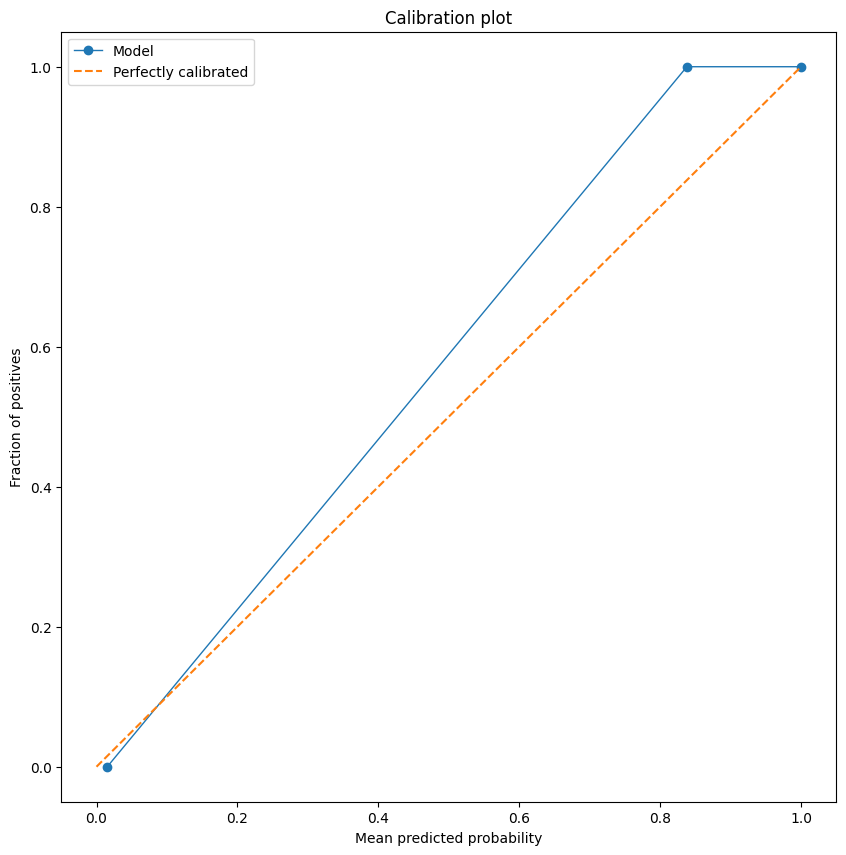

AUC: 1.0
Balanced Accuracy: 1.0
Sensitivity: 0.5
Specificity: 0.5
Brier Score: 0.0018628540501191696
Expected Calibration Error (ECE): 0.05923558348281621


In [10]:
# Evaluate stats on the validation set
preds, y_true = classifier.generate_predictions(subset='val')
classifier.evaluate_stats(preds, y_true)

Generating predictions on test set...


d:\Formation\AI_FOR_MEDECINE\CHEST_CLASSIFCATION\chest_classification_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


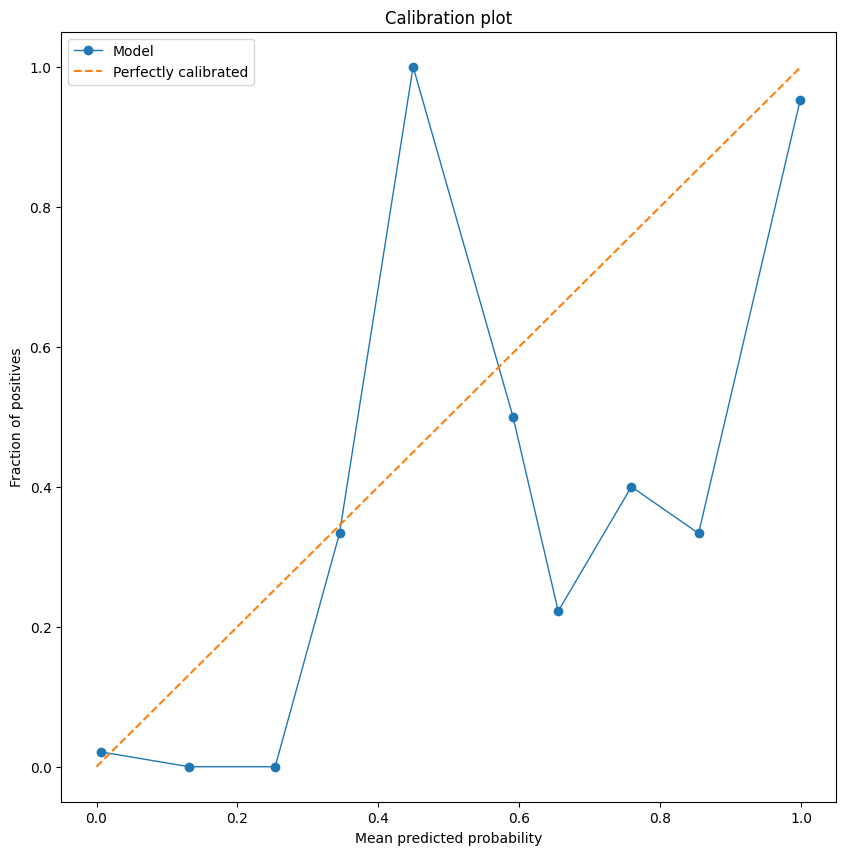

AUC: 0.974222003068157
Balanced Accuracy: 0.917094017094017
Sensitivity: 0.6666666666666666
Specificity: 0.3333333333333333
Brier Score: 0.05340584580884983
Expected Calibration Error (ECE): 0.24137177271525417


In [11]:
# Evaluate stats on the test set
preds, y_true = classifier.generate_predictions(subset='test')
classifier.evaluate_stats(preds, y_true)

In [12]:
# Enhance calibration using Platt Scaling
platt_model =classifier.enhance_calibration()

Enhancing calibration using Platt Scaling using validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


Applying Platt Scaling on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


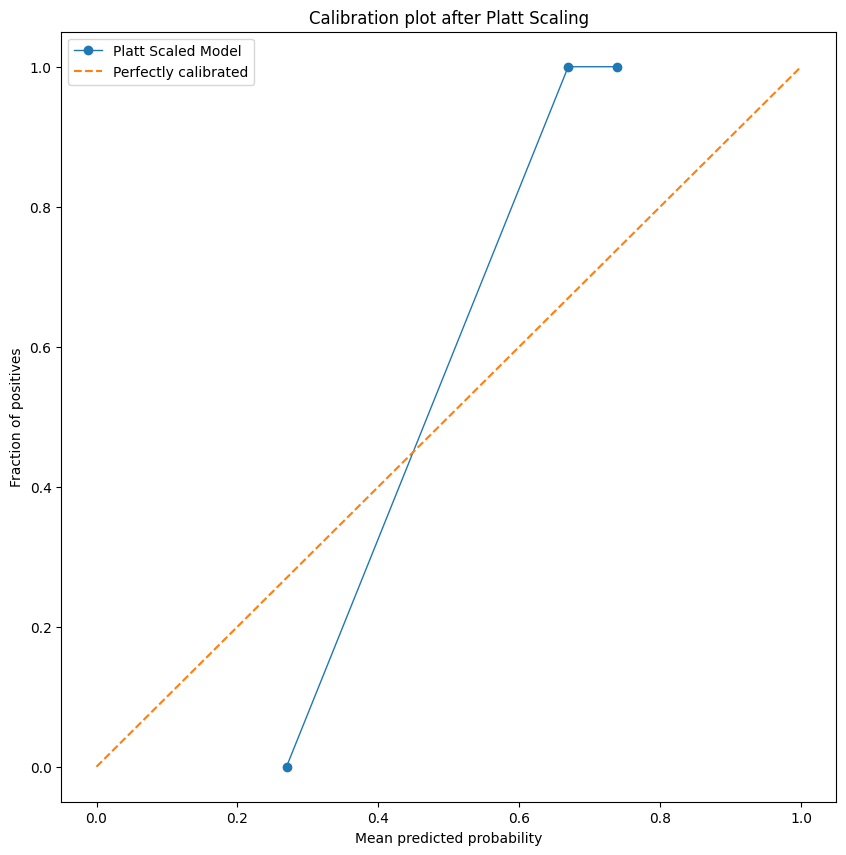

AUC after Platt Scaling: 1.0
Balanced Accuracy after Platt Scaling: 1.0
Sensitivity after Platt Scaling: 1.0
Specificity after Platt Scaling: 1.0
Brier Score after Platt Scaling: 0.07301084142597711
Expected Calibration Error (ECE) after Platt Scaling: 0.28704660196171544


In [13]:
# Apply Platt Scaling on the validation set
classifier.apply_platt_scaling(platt_model, subset='val')

Applying Platt Scaling on test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


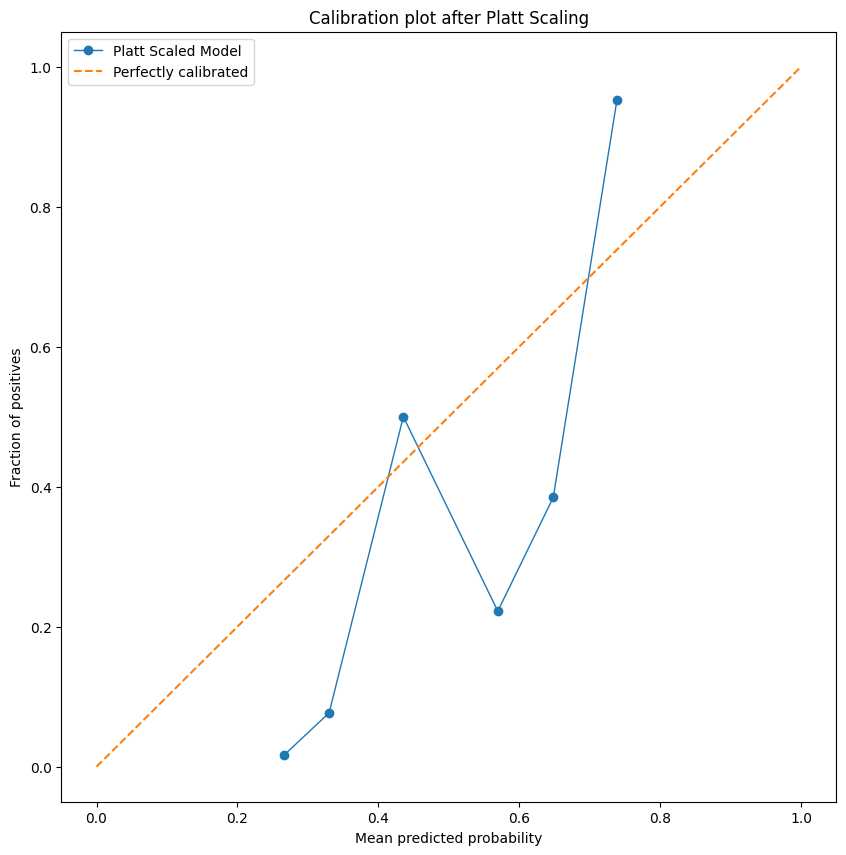

AUC after Platt Scaling: 0.974222003068157
Balanced Accuracy after Platt Scaling: 0.917094017094017
Sensitivity after Platt Scaling: 0.9794871794871794
Specificity after Platt Scaling: 0.8547008547008547
Brier Score after Platt Scaling: 0.0976429030808032
Expected Calibration Error (ECE) after Platt Scaling: 0.23191736459309611


In [14]:
# Apply Platt Scaling on the test set
classifier.apply_platt_scaling(platt_model, subset='test')